In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,mean_squared_error,mean_absolute_error,r2_score
import mlflow 
from mlflow.models import infer_signature
import os
import boto3
from io import StringIO
import s3fs


sns.set_theme()
sns.set_context("paper")

warnings.filterwarnings("ignore")

In [21]:
s3_client= boto3.client(
    's3',
    region_name="us-east-1",
    aws_access_key_id= "xxx",
    aws_secret_access_key = "qQhoBPHf+xxxx+czmaxuyVXU"
,
)

# Define the file name you want to save as in S3
BUCKET = "insurance-claims-deploy"
s3_key = "training_data/train.csv"  # Replace with the desired key (filename) in the S3 bucket

#Load the CSV file from S3
csv_obj = s3_client.get_object(Bucket=BUCKET, Key=s3_key)
body = csv_obj['Body'].read().decode('utf-8')

#Convert the CSV data to a Pandas DataFrame
data = pd.read_csv(StringIO(body))
data.head()

,subscription_length,vehicle_age,customer_age,region_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,...,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,transmission_type_Automatic,transmission_type_Manual,steering_type_Electric,steering_type_Manual,steering_type_Power
0,9.3,1.2,41,8794,6,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
1,8.2,1.8,35,27003,2,0,1,0,1,1,...,0,0,0,0,1,0,1,1,0,0
2,9.5,0.2,44,8794,6,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
3,5.2,0.4,44,73430,2,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
4,10.1,1.0,56,5410,2,0,1,0,1,0,...,0,0,0,0,0,0,1,1,0,0


In [23]:
X= data.drop(columns=['claim_status'])
y= data["claim_status"]

### Model Tracking with Mlflow

In [76]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://ec2-100-29-189-194.compute-1.amazonaws.com:5000/")
 

In [78]:
# Create a new MLflow Experiment
mlflow.set_experiment("Insurance_Claim")

2024/08/28 23:07:46 INFO mlflow.tracking.fluent: Experiment with name 'Insurance_Claim' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://insurance-claims-deploy/mlflowmodel/607834067422891445', creation_time=1724882867059, experiment_id='607834067422891445', last_update_time=1724882867059, lifecycle_stage='active', name='Insurance_Claim', tags={}>

In [30]:
# define evaluation metrics 
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    acc=accuracy_score(actual,pred)
    return rmse, mae, r2,acc

In [34]:
#test train split

X_train,X_test,y_train,y_test= train_test_split (X,y, test_size=0.35, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

2024/08/28 23:10:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


              precision    recall  f1-score   support

           0       0.96      0.56      0.71     19185
           1       0.09      0.63      0.16      1323

    accuracy                           0.57     20508
   macro avg       0.52      0.59      0.43     20508
weighted avg       0.90      0.57      0.67     20508

[[10784  8401]
 [  493   830]]


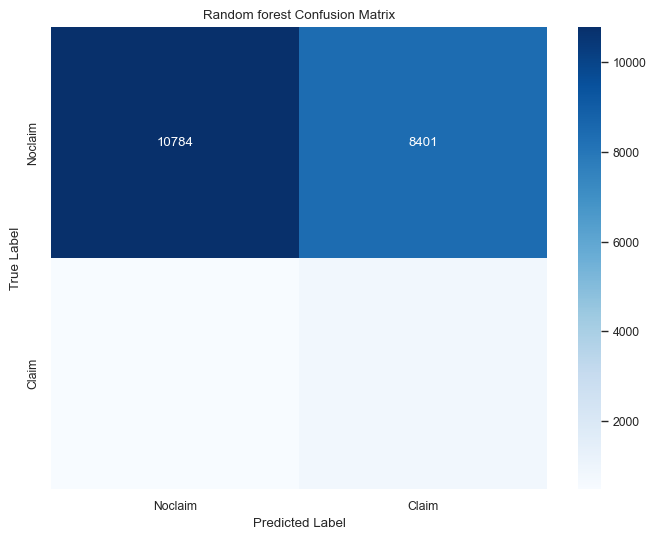

2024/08/28 23:10:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random forest at: http://ec2-100-29-189-194.compute-1.amazonaws.com:5000/#/experiments/607834067422891445/runs/9780829a46234751ac790701fabc24b0.
2024/08/28 23:10:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-100-29-189-194.compute-1.amazonaws.com:5000/#/experiments/607834067422891445.
2024/08/28 23:10:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     19185
           1       0.13      0.00      0.01      1323

    accuracy                           0.93     20508
   macro avg       0.53      0.50      0.49     20508
weighted avg       0.88      0.93      0.90     20508

[[19159    26]
 [ 1319     4]]


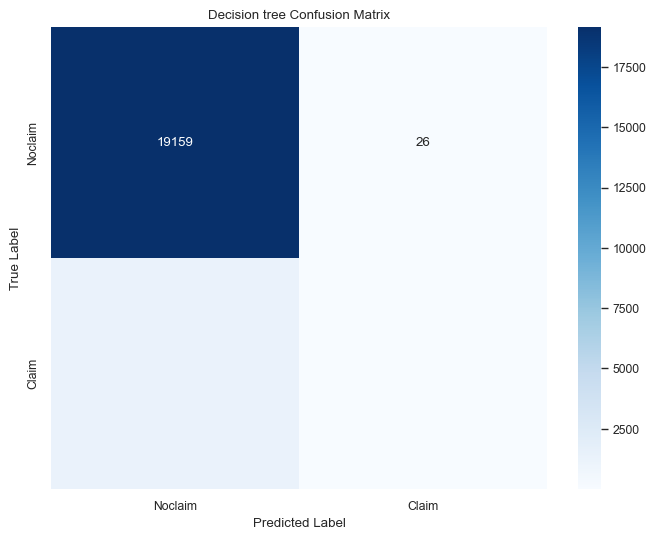

2024/08/28 23:10:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Decision tree at: http://ec2-100-29-189-194.compute-1.amazonaws.com:5000/#/experiments/607834067422891445/runs/60cebd6b6d4741ab96dc87cb002dac1f.
2024/08/28 23:10:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-100-29-189-194.compute-1.amazonaws.com:5000/#/experiments/607834067422891445.


In [84]:
# Create a temporary directory for storing confusion matrix images
artifact_dir = "confusion_matrices"
os.makedirs(artifact_dir, exist_ok=True)


# define model parameters
random_param={'n_estimators': 100,
              'class_weight':'balanced', 
            'max_depth':2, 
            'random_state':4}

decision_param={"random_state": 24,
                'splitter':'best',
                'max_depth':10,
                'min_samples_split':5,
                'min_samples_leaf':4,
                'max_features':'sqrt',
                'random_state':42}



# Initialize models with parameters
mlmodel= {"Random forest":RandomForestClassifier(**random_param),
         "Decision tree":DecisionTreeClassifier(**decision_param)}

# store results
results= []

# store column name

column_names= X.columns.tolist()

for name,model in mlmodel.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train,y_train)
        
        #make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
        #evaluate train model performance 
        train_rmse,train_r2,train_mae,train_acc = eval_metrics(y_train,y_pred_train)
    
        #evaluate test model performance 
        test_rmse,test_r2,test_mae,test_acc = eval_metrics(y_test,y_pred_test)
    
        #store test model results
    
        results.append({"model":name,
                   "Accuracy": test_acc})
        
        #log parameters parameters
        if name == "Random forest":
            for param_name, param_value in random_param.items():
                mlflow.log_param(param_name, param_value)
        elif name == "Decision tree":
            for param_name, param_value in decision_param.items():
                mlflow.log_param(param_name, param_value)
       
        # log model 
        mlflow.sklearn.log_model(model,"model")
        
        # Log metrics to MLflow
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("train_r2", train_r2)
        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("train_acc", train_acc)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("test_r2", test_r2)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("test_acc", test_acc)
        
        # Log the classification report as an artifact
        classification_rep = classification_report(y_test, y_pred_test, output_dict=True)
        classification_df = pd.DataFrame(classification_rep).transpose()
        classification_report_path = os.path.join(artifact_dir, f"{name}_classification_report.csv")
        classification_df.to_csv(classification_report_path)
        mlflow.log_artifact(classification_report_path)
    
        print(classification_report(y_test, y_pred_test))
    
        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print(cm)

        # Visualize the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Noclaim','Claim'],  
                    yticklabels=['Noclaim', 'Claim'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'{name} Confusion Matrix')

        # Save confusion matrix plot as an image file and log as an artifact
        confusion_matrix_path = os.path.join(artifact_dir, f"{name}_confusion_matrix.png")
        plt.savefig(confusion_matrix_path)
        mlflow.log_artifact(confusion_matrix_path)
        plt.show()
        
        column_file="columns.txt"
        with open(column_file,"w") as f:
            for col in column_names:
                f.write(f"{col}\n")
        #log text file
        mlflow.log_artifact(column_file)

In [86]:
results_df=pd.DataFrame(results)
results_df

,model,Accuracy
0,Random forest,0.566316
1,Decision tree,0.934416


In [94]:
data=pd.read_csv("sam_test.csv",header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,46,10,46,2791,6,1,0,1,0,1,...,0,1,0,1,0,1,0,1,0,0
1,4,14,44,2125,5,1,0,0,0,1,...,0,0,1,0,1,0,1,0,0,0
2,5,13,34,4032,2,1,1,0,0,0,...,0,1,1,0,1,1,0,1,0,1
3,56,8,38,2960,9,0,1,0,0,0,...,0,0,1,0,0,1,0,1,1,1
4,36,2,22,2086,1,1,0,0,0,0,...,1,1,0,1,1,0,0,0,1,0


In [96]:
import mlflow
logged_model = 'runs:/60cebd6b6d4741ab96dc87cb002dac1f/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,